In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import numpy as np
sys.path.append(f'../../')

In [3]:
import pandas as pd
from gensim.models import FastText
from src.features.retrofitting import *
from src.data.sentence_vectorizer import SentenceVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kaigorodov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kaigorodov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
smm4h21_train = pd.read_csv('../../data/interim/smm4h21/train.csv')
smm4h21_test = pd.read_csv('../../data/interim/smm4h21/test.csv')

In [5]:
ft_model = FastText.load_fasttext_format('../../data/external/embeddings/cc.en.300.bin')
ft_model

/home/kaigorodov/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [6]:
from copy import deepcopy

def vectorize_sent(sent):
    return np.array([ft_model.wv[w] for w in sent.split()]).mean(axis=0)

def retrofitting(word_vec, lexicons_vecs, iters=1):
    if len(lexicons_vecs) == 0:
        return word_vec
    new_word_vec = deepcopy(word_vec)
    for iteration in range(iters):
        new_word_vec *= len(lexicons_vecs)
        for lexicons_vec in lexicons_vecs:
            new_word_vec += lexicons_vec
        new_word_vec /= 2 * len(lexicons_vecs)
    return new_word_vec

def retrofit_row(row):
    concept = row['STR']
    synonims = set(eval(row['SNMS']))
    concept_vec = vectorize_sent(concept)
    lexicons_vecs = [vectorize_sent(syn) for syn in synonims]
    concept_vec = retrofitting(concept_vec, lexicons_vecs)
    return concept_vec

In [7]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

In [8]:
DIM = 10

In [9]:
X_train = smm4h21_train['term'].apply(lambda row: vectorize_sent(row)[:DIM])
X_train = pd.DataFrame(X_train.values.tolist()).dropna().values

y_train = smm4h21_train.apply(lambda row: retrofit_row(row)[:DIM], axis=1)
y_train = pd.DataFrame(y_train.values.tolist()).dropna().values
X_train.shape, y_train.shape

((1512, 10), (1512, 10))

In [10]:
X_test = smm4h21_test['term'].apply(lambda row: vectorize_sent(row)[:DIM])
X_test = pd.DataFrame(X_test.values.tolist()).dropna().values

y_test = smm4h21_test.apply(lambda row: retrofit_row(row)[:DIM], axis=1)
y_test = pd.DataFrame(y_test.values.tolist()).dropna().values
X_test.shape, y_test.shape

((287, 10), (287, 10))

In [11]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(1, 20):
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train, y_train)
    print('R2', neigh.score(X_test,y_test))

R2 0.13393389606189482
R2 0.23893949322197666
R2 0.2833554379972198
R2 0.2970326029055908
R2 0.29080484665241535
R2 0.29146807545766473
R2 0.2928355574349053
R2 0.29892117186396805
R2 0.2914062486894878
R2 0.2881320001089448
R2 0.28808621833680964
R2 0.2844415109632962
R2 0.28245175925280963
R2 0.27782073747938274
R2 0.27126929421711327
R2 0.26732873433289706
R2 0.2621997312934451
R2 0.26005890460942194
R2 0.2600746468564027


In [12]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(X_train, y_train)

NearestNeighbors(n_neighbors=1)

In [13]:
neigh.kneighbors(X_test)

(array([[0.06236535],
        [0.        ],
        [0.0565007 ],
        [0.13210999],
        [0.07909912],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.10106691],
        [0.        ],
        [0.13705717],
        [0.09143256],
        [0.05086524],
        [0.05581114],
        [0.        ],
        [0.        ],
        [0.04656425],
        [0.        ],
        [0.16668339],
        [0.05221045],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.09228949],
        [0.07687752],
        [0.15225909],
        [0.        ],
        [0.10647095],
        [0.1231611 ],
        [0.        ],
        [0.07003382],
        [0.        ],
        [0.        ],
        [0.0692636 ],
        [0.        ],
        [0.        ],
        [0.13381531],
        [0.        ],
        [0.03401673],
        [0.08679713],
        [0

In [14]:
case = 154
t, p = neigh.kneighbors([X_test[122]])
t = case
p = int(p[0][0])
t, p

(154, 1077)

In [15]:
#smm4h21_test.iloc[t]['term'], smm4h21_test.iloc[p]['STR']

In [16]:
def predict_concept(term):
    term = vectorize_sent(term)[:DIM]
    concept_pred = neigh.predict(term)
    

# COSINE NET

In [17]:
import tensorflow as tf

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
term = np.array(tf.constant([1, 2, 3], shape=[3]))
concepts = np.array(tf.constant([[1, 2, 4], [1, 2, 3]], shape=[2, 3]))
cosine_similarity([term], [concepts[0]]), cosine_similarity([term], [concepts[1]])

(array([[0.99146013]]), array([[1.]]))

In [19]:
def cosine_mul_fun(inputs):
    a, b = inputs[0], inputs[1]
    normalize_a = tf.nn.l2_normalize(a,1)        
    normalize_b = tf.nn.l2_normalize(b,1)
    distance = 1 - tf.matmul([normalize_a], normalize_b, transpose_b=True)
    print(distance)
    return distance[0]

n_terms = 10
embedding_size = 20
n_concepts = 5

inputs1 =    tf.keras.layers.Input(shape=(embedding_size), name='term')
dn =         tf.keras.layers.Dense(2 * embedding_size)(inputs1)
dn =         tf.keras.layers.Dense(embedding_size)(dn)
term_hat =   tf.keras.layers.Flatten()(dn)
inputs2 =    tf.keras.layers.Input(shape=(n_concepts, embedding_size), name='concepts')
cosine_mul = tf.keras.layers.Lambda(cosine_mul_fun)([term_hat, inputs2])
activation = tf.keras.layers.ReLU()(cosine_mul)
output =     tf.keras.layers.Dense(n_concepts, activation='softmax')(activation)

model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss="categorical_crossentropy")
model.summary()

Tensor("lambda/sub:0", shape=(None, None, 5), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term (InputLayer)               [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40)           840         term[0][0]                       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 20)           820         dense[0][0]                      
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20)           0           dense_1[0][0]                    
_________________________________

In [20]:
X_train = [np.arange(n_terms * embedding_size).reshape(-1, embedding_size), np.arange(n_terms * n_concepts*embedding_size).reshape(-1, n_concepts, embedding_size)]
y_train = np.array([[0, 1, 0, 0, 0]])
y_train = np.vstack([y_train]*n_terms)
X_train[0].shape, X_train[1].shape, y_train.shape

((10, 20), (10, 5, 20), (10, 5))

In [21]:
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
Tensor("model/lambda/sub:0", shape=(None, None, 5), dtype=float32)
Tensor("model/lambda/sub:0", shape=(None, None, 5), dtype=float32)
1/1 [==============================] - 0s 417ms/step - loss: 2.6497
Epoch 2/3
1/1 [==============================] - 0s 3ms/step - loss: 2.5645
Epoch 3/3
1/1 [==============================] - 0s 2ms/step - loss: 2.5149


In [22]:
terms = np.arange(n_terms * embedding_size).reshape(-1, embedding_size)
concepts = np.arange(n_terms * n_concepts*embedding_size).reshape(-1, n_concepts, embedding_size)
preds = model.predict([terms, concepts])
[np.argmax(pred) for pred in preds]

Tensor("model/lambda/sub:0", shape=(None, None, 5), dtype=float32)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
preds

array([[0.36509502, 0.08156148, 0.20160426, 0.2288418 , 0.12289742],
       [0.36505193, 0.08144022, 0.20156495, 0.22941282, 0.12252999],
       [0.3650502 , 0.08134759, 0.20153531, 0.22978988, 0.12227702],
       [0.36505038, 0.08129927, 0.20151979, 0.22998415, 0.12214635],
       [0.36505076, 0.08127021, 0.20151043, 0.23010045, 0.12206812],
       [0.3650511 , 0.08125092, 0.20150422, 0.23017754, 0.12201623],
       [0.36505133, 0.08123722, 0.20149978, 0.23023225, 0.12197941],
       [0.36505157, 0.08122696, 0.20149647, 0.23027311, 0.12195189],
       [0.36505175, 0.08121902, 0.20149387, 0.23030476, 0.12193062],
       [0.3650519 , 0.08121269, 0.20149185, 0.23032996, 0.12191364]],
      dtype=float32)

In [24]:
terms.shape, preds.shape, concepts.shape

((10, 20), (10, 5), (10, 5, 20))

# Create train and test sets for NET

In [297]:
from copy import copy

In [313]:
codes = set(list(set(smm4h21_train['code'].tolist() + smm4h21_test['code'].tolist())))
len(codes)

484

In [314]:
terms_train = copy(smm4h21_train)
terms_vecs_train = terms_train.apply(lambda row: vectorize_sent(row['term']), axis=1)
terms_vecs_train = pd.DataFrame(terms_vecs_train.values.tolist()).dropna().values

terms_test = copy(smm4h21_test)
terms_vecs_test = terms_test.apply(lambda row: vectorize_sent(row['term']), axis=1)
terms_vecs_test = pd.DataFrame(terms_vecs_test.values.tolist()).dropna().values

In [315]:
#concepts = pd.read_csv('../../data/interim/used_codes.csv')[['code', 'STR', 'SNMS']]
concepts = pd.read_csv('../../data/interim/used_codes_big.csv')[['code', 'STR', 'SNMS']]

# только те которые есть
#concepts = concepts[concepts['code'].isin(codes)].reset_index(drop=True).reset_index().set_index('code')

# все доступные
#concepts = concepts.reset_index(drop=True).reset_index().set_index('code')

# все из трейна
concepts = concepts[concepts['code'].isin(terms_train['code'])].reset_index(drop=True).reset_index().set_index('code')

codes = concepts['index'].to_numpy()
concepts_vecs = concepts.apply(lambda row: retrofit_row(row), axis=1)
concepts_vecs = pd.DataFrame(concepts_vecs.values.tolist()).dropna().values
codes.shape

(440,)

In [301]:
# concepts_selected = concepts[concepts.index.isin(terms_train['code'])]


# concepts_to_select = concepts[~concepts.index.isin(terms_train['code'])]
# concepts_to_select_vecs = concepts_to_select.apply(lambda row: retrofit_row(row), axis=1)
# concepts_to_select_vecs = pd.DataFrame(concepts_to_select_vecs.values.tolist()).dropna().values

# from src.features.novelty_detector import NoveltyDetector
# nd = NoveltyDetector(n_neighbors=1, contamination=0.5) 

# nd.fit(terms_vecs_train)
# X_novelties, X_not_novelties, novpred = nd.select_novelties(concepts_to_select_vecs)
# np.unique(novpred, return_counts=True)

# concepts_vecs = concepts_vecs[novpred]
# codes = codes[novpred]


# concepts_to_select = concepts_to_select[[True if i ==1 else False for i in novpred]]
# concepts = pd.concat([concepts_selected, concepts_to_select])
# concepts = concepts.reset_index().drop(columns=['index']).reset_index().set_index('code')

# codes = concepts['index'].to_numpy()
# concepts_vecs = concepts.apply(lambda row: retrofit_row(row), axis=1)
# concepts_vecs = pd.DataFrame(concepts_vecs.values.tolist()).dropna().values

In [302]:
terms_codes_train = terms_train['code'].apply(lambda code: concepts.loc[code]['index'])

In [303]:
terms_codes_test = terms_test['code'].apply(
    lambda code: concepts.loc[code]['index'] if code in concepts.index else len(codes)) #OOV CODE
terms_codes_train.max(), terms_codes_test.max()

(439, 440)

In [304]:
terms_codes_train = tf.keras.utils.to_categorical(
    terms_codes_train, num_classes=len(codes)+1, dtype='float32'
)
terms_codes_test = tf.keras.utils.to_categorical(
    terms_codes_test, num_classes=len(codes)+1, dtype='float32'
)

In [305]:
def data_generator(terms_vecs, terms_codes, concepts_vecs, batch_size=50):
    while 1:

        concepts_vecs_choosed = []
        
        index_to_choose = np.random.choice(terms_vecs.shape[0]-batch_size)
        concepts_vecs_choosed.append(concepts_vecs)
            
        terms_vecs_choosed = terms_vecs[index_to_choose:index_to_choose+batch_size]
        terms_codes_choosed = terms_codes[index_to_choose:index_to_choose+batch_size]
        concepts_vecs_choosed = np.array(concepts_vecs_choosed, dtype='float32')
        
        train = [terms_vecs_choosed, concepts_vecs_choosed]
        test = [terms_codes_choosed]
        yield train, test


In [306]:
def cosine_mul_fun(inputs):
    a, b = inputs[0], inputs[1]
    normalize_a = tf.nn.l2_normalize(a,1)        
    normalize_b = tf.nn.l2_normalize(b,1)
    distance = 1 - tf.matmul([normalize_a], normalize_b, transpose_b=True)
    return distance[0]

In [311]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

n_concepts = len(codes)
embedding_size = 300

def get_model():
    inputs1 =    tf.keras.layers.Input(shape=(embedding_size), name='term')
    dn =         tf.keras.layers.Dense(512)(inputs1)
    dn =         tf.keras.layers.Dense(embedding_size)(dn)
    term_hat =   tf.keras.layers.Flatten()(dn)
    inputs2 =    tf.keras.layers.Input(shape=(n_concepts, embedding_size), name='concepts')
    cosine_mul = tf.keras.layers.Lambda(cosine_mul_fun)([term_hat, inputs2])
    activation = tf.keras.layers.ReLU()(cosine_mul)
    output =     tf.keras.layers.Dense(n_concepts+1, activation='softmax')(activation)

    model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[output])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.001), 
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )
    return model

model = get_model()
model.summary()

Model: "model_60"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
term (InputLayer)               [(None, 300)]        0                                            
__________________________________________________________________________________________________
dense_169 (Dense)               (None, 512)          154112      term[0][0]                       
__________________________________________________________________________________________________
dense_170 (Dense)               (None, 300)          153900      dense_169[0][0]                  
__________________________________________________________________________________________________
flatten_51 (Flatten)            (None, 300)          0           dense_170[0][0]                  
___________________________________________________________________________________________

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/80
150/150 - 2s - loss: 4.8444 - categorical_accuracy: 0.1339 - val_loss: 5.8521 - val_categorical_accuracy: 0.2148
Epoch 2/80
150/150 - 1s - loss: 3.9647 - categorical_accuracy: 0.2943 - val_loss: 5.6078 - val_categorical_accuracy: 0.2600
Epoch 3/80
150/150 - 1s - loss: 3.3716 - categorical_accuracy: 0.3961 - val_loss: 5.3985 - val_categorical_accuracy: 0.2659
Epoch 4/80
150/150 - 1s - loss: 2.9368 - categorical_accuracy: 0.4678 - val_loss: 5.2778 - val_categorical_accuracy: 0.3419
Epoch 5/80
150/150 - 1s - loss: 2.5552 - categorical_accuracy: 0.5291 - val_loss: 5.1493 - val_categorical_accuracy: 0.3576
Epoch 6/80
150/150 - 1s - loss: 2.2788 - categorical_accuracy: 0.5773 - val_loss: 5.0865 - val_categorical_accuracy: 0.3814
Epoch 7/80
150/150 - 1s - loss: 2.0608 - categorical_accuracy: 0.6215 - val_loss: 5.0079 - val_categorical_accuracy: 0.4237
Epoch 8/80
150/150 - 1s - loss: 1.8160 - categorical_accuracy: 0.6689 - val_loss: 4.9622 - val_categorical_accuracy: 0.4241
Epoch 9/

 33%|███▎      | 1/3 [00:40<01:20, 40.29s/it]

0.9342187643051147 0.4815104305744171
Epoch 1/80
150/150 - 2s - loss: 4.8610 - categorical_accuracy: 0.1393 - val_loss: 5.6190 - val_categorical_accuracy: 0.1957
Epoch 2/80
150/150 - 1s - loss: 3.9487 - categorical_accuracy: 0.3049 - val_loss: 5.4309 - val_categorical_accuracy: 0.2868
Epoch 3/80
150/150 - 1s - loss: 3.3971 - categorical_accuracy: 0.3969 - val_loss: 5.1945 - val_categorical_accuracy: 0.2749
Epoch 4/80
150/150 - 1s - loss: 2.9410 - categorical_accuracy: 0.4748 - val_loss: 5.0469 - val_categorical_accuracy: 0.3359
Epoch 5/80
150/150 - 1s - loss: 2.6142 - categorical_accuracy: 0.5324 - val_loss: 4.8730 - val_categorical_accuracy: 0.3652
Epoch 6/80
150/150 - 1s - loss: 2.3043 - categorical_accuracy: 0.5732 - val_loss: 4.9083 - val_categorical_accuracy: 0.3948
Epoch 7/80
150/150 - 1s - loss: 2.0154 - categorical_accuracy: 0.6230 - val_loss: 4.7798 - val_categorical_accuracy: 0.4158
Epoch 8/80
150/150 - 1s - loss: 1.8750 - categorical_accuracy: 0.6564 - val_loss: 4.7334 - val

 67%|██████▋   | 2/3 [01:19<00:39, 39.88s/it]

0.9342968463897705 0.4815104305744171
Epoch 1/80
150/150 - 2s - loss: 4.8575 - categorical_accuracy: 0.1331 - val_loss: 5.3829 - val_categorical_accuracy: 0.2029
Epoch 2/80
150/150 - 1s - loss: 3.9793 - categorical_accuracy: 0.2951 - val_loss: 5.0392 - val_categorical_accuracy: 0.2823
Epoch 3/80
150/150 - 1s - loss: 3.3766 - categorical_accuracy: 0.4071 - val_loss: 4.9208 - val_categorical_accuracy: 0.2945
Epoch 4/80
150/150 - 1s - loss: 2.9059 - categorical_accuracy: 0.4778 - val_loss: 4.7911 - val_categorical_accuracy: 0.3451
Epoch 5/80
150/150 - 1s - loss: 2.5357 - categorical_accuracy: 0.5323 - val_loss: 4.6513 - val_categorical_accuracy: 0.3736
Epoch 6/80
150/150 - 1s - loss: 2.2274 - categorical_accuracy: 0.5909 - val_loss: 4.6102 - val_categorical_accuracy: 0.3836
Epoch 7/80
150/150 - 1s - loss: 2.0150 - categorical_accuracy: 0.6325 - val_loss: 4.4790 - val_categorical_accuracy: 0.4296
Epoch 8/80
150/150 - 1s - loss: 1.8373 - categorical_accuracy: 0.6661 - val_loss: 4.4360 - val

100%|██████████| 3/3 [02:05<00:00, 41.93s/it]

0.93729168176651 0.5059896111488342


('SCORES:', 0.9352690974871317, 0.48967015743255615)

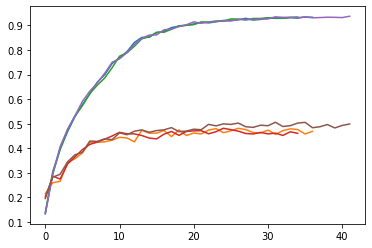

In [312]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_categorical_accuracy",
            min_delta=0,
            patience=10,
            verbose=0,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )

BATCH_SIZE = 256
train_gen = data_generator(terms_vecs_train, terms_codes_train, concepts_vecs, batch_size=BATCH_SIZE)
test_gen = data_generator(terms_vecs_test, terms_codes_test, concepts_vecs, batch_size=BATCH_SIZE)

train_acc_scores, test_acc_scores = [], []
for iteration in tqdm(range(3)):
    model = get_model()
    
    history = model.fit_generator(train_gen, 
              epochs=80,
              verbose=2,
              steps_per_epoch=150,
              validation_data=test_gen, validation_steps=30,
              callbacks=[early_stopping_callback])

    max_train = np.array(history.history['categorical_accuracy']).max()
    max_val   = np.array(history.history['val_categorical_accuracy']).max()
    train_acc_scores.append(max_train)
    test_acc_scores.append(max_val)
    print(max_train, max_val)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    
"SCORES:", np.array(train_acc_scores).mean(), np.array(test_acc_scores).mean()